https://github.com/chl8856/DeepHit

https://github.com/havakv/pycox

https://humboldt-wi.github.io/blog/research/information_systems_1920/group2_survivalanalysis/


In [1]:
#!pip install sklearn_pandas
#!pip install torchtuples
#!pip install pycox
import pandas as pd
import numpy as np
import sklearn_pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import seaborn as sns

sns.set_style("white")

import torch # For building the networks 
import torchtuples as tt # Some useful functions
from torch import nn
import torch.nn.functional as F

from pycox.datasets import support
from pycox.models import DeepHitSingle
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models.loss import rank_loss_deephit_single

In [2]:
np.random.seed(42)
_ = torch.manual_seed(8)

In [2]:
df_train = support.read_df()

In [236]:
df_train['x2'].value_counts()

1.0    2925
2.0    2337
3.0    1390
0.0    1148
4.0     698
5.0     258
6.0      95
7.0      19
8.0       2
9.0       1
Name: x2, dtype: int64

In [21]:
df_train['x3'].value_counts()

1.0    6998
2.0    1365
3.0     283
0.0     110
4.0      76
5.0      41
Name: x3, dtype: int64

In [229]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8873 entries, 0 to 8872
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x0        8873 non-null   float32
 1   x1        8873 non-null   float32
 2   x2        8873 non-null   float32
 3   x3        8873 non-null   float32
 4   x4        8873 non-null   float32
 5   x5        8873 non-null   float32
 6   x6        8873 non-null   float32
 7   x7        8873 non-null   float32
 8   x8        8873 non-null   float32
 9   x9        8873 non-null   float32
 10  x10       8873 non-null   float32
 11  x11       8873 non-null   float32
 12  x12       8873 non-null   float32
 13  x13       8873 non-null   float32
 14  duration  8873 non-null   float32
 15  event     8873 non-null   int32  
dtypes: float32(15), int32(1)
memory usage: 554.7 KB


In [22]:
df_train.rename(columns={'x0': 'age', 'x1': 'sex', 'x2': 'race', 'x3': 'num_comorb', 'x4': 'diab', 'x5': 'dementia', 
                         'x6': 'cancer', 'x7': 'mean_arterial_bp', 'x8': 'hr', 'x9': 'resp', 'x10': 'temp', 'x11': 'serum_na', 
                         'x12': 'wbc','x13': 'serum_creat'}, inplace=True)

In [23]:
df_train.head()

,age,sex,race,num_comorb,diab,dementia,cancer,mean_arterial_bp,hr,resp,temp,serum_na,wbc,serum_creat,duration,event
0,82.709961,1.0,2.0,1.0,0.0,0.0,0.0,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854,30.0,1
1,79.660950,1.0,0.0,1.0,0.0,0.0,1.0,54.0,67.0,16.0,38.000000,142.0,10.000000,0.899902,1527.0,0
2,23.399990,1.0,2.0,3.0,0.0,0.0,1.0,87.0,144.0,45.0,37.296879,130.0,5.199219,1.199951,96.0,1
3,53.075989,1.0,4.0,3.0,0.0,0.0,0.0,55.0,100.0,18.0,36.000000,135.0,8.699219,0.799927,892.0,0
4,71.794983,0.0,1.0,1.0,0.0,0.0,0.0,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963,7.0,1


In [76]:
df_train.isnull().sum()

age                 0
sex                 0
race                0
num_comorb          0
diab                0
dementia            0
cancer              0
mean_arterial_bp    0
hr                  0
resp                0
temp                0
wbc                 0
serum_na            0
serum_creat         0
duration            0
event               0
dtype: int64

In [5]:
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [82]:
df_train.head()

,age,sex,race,num_comorb,diab,dementia,cancer,mean_arterial_bp,hr,resp,temp,wbc,serum_na,serum_creat,duration,event
0,82.709961,1.0,2.0,1.0,0.0,0.0,0.0,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854,30.0,1
1,79.660950,1.0,0.0,1.0,0.0,0.0,1.0,54.0,67.0,16.0,38.000000,142.0,10.000000,0.899902,1527.0,0
3,53.075989,1.0,4.0,3.0,0.0,0.0,0.0,55.0,100.0,18.0,36.000000,135.0,8.699219,0.799927,892.0,0
4,71.794983,0.0,1.0,1.0,0.0,0.0,0.0,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963,7.0,1
5,49.932980,0.0,1.0,1.0,0.0,0.0,0.0,70.0,105.0,33.0,38.195309,127.0,5.299805,1.199951,50.0,1


In [83]:
df_train.describe()

,age,sex,race,num_comorb,diab,dementia,cancer,mean_arterial_bp,hr,resp,temp,wbc,serum_na,serum_creat,duration,event
count,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000
mean,62.606041,0.441881,1.861747,1.247094,0.196548,0.030997,0.936069,84.624779,97.675835,23.337442,37.113201,137.620285,12.315069,1.778243,479.857697,0.678408
std,15.753716,0.496667,1.331220,0.613437,0.397423,0.173325,0.576031,27.723907,31.550598,9.676876,1.253956,6.062066,8.958986,1.740100,556.772339,0.467129
min,18.041990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.093750,112.000000,0.000000,0.099991,3.000000,0.000000
25%,52.583490,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,63.000000,72.000000,18.000000,36.195309,134.000000,7.000000,0.899902,26.000000,0.000000
50%,64.922485,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000,77.000000,100.000000,24.000000,36.695309,137.000000,10.599609,1.199951,243.500000,1.000000
75%,74.143988,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000,107.000000,120.000000,28.000000,38.195309,141.000000,15.298828,1.899902,768.750000,1.000000
max,101.847961,1.000000,8.000000,5.000000,1.000000,1.000000,2.000000,195.000000,250.000000,90.000000,41.296879,175.000000,113.593750,21.500000,2029.000000,1.000000


<AxesSubplot:xlabel='event', ylabel='count'>

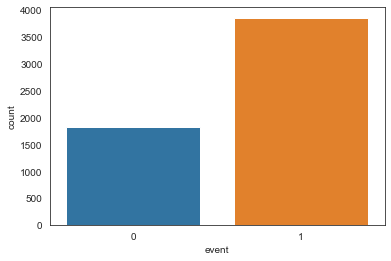

In [68]:
# visualizing event variable
sns.countplot(x="event", data=df_train)

# Vanilla MLP with equidistant discretization grid

## w/o categorical embeddings

In [6]:
cols_std = ['age', 'mean_arterial_bp', 'hr', 'resp', 'temp', 'wbc', 'serum_na', 'serum_creat', 'num_comorb', 'race', 'cancer' ]
cols_ = ['sex', 'diab', 'dementia']


standardize = [([col], StandardScaler()) for col in cols_std]
leave = [(col, None) for col in cols_]


x_mapper = DataFrameMapper(standardize + leave)

In [7]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')


In [8]:
num_durations = 10

labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

## 1 layer 32 nodes

In [9]:
in_features = x_train.shape[1]
out_features = labtrans.out_features
num_nodes = [32]
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [10]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_0a = DeepHitSingle(net, optimizer, alpha = 0.2, sigma = 0.1, duration_index=labtrans.cuts)

C:\Users\Ryan\anaconda3\lib\site-packages\torchtuples\callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1005.)
  p.data = p.data.add(-weight_decay * eta, p.data)


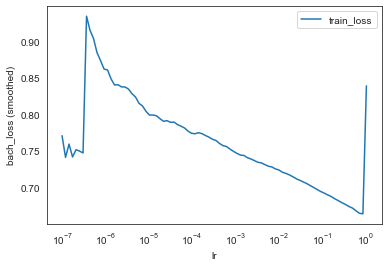

In [13]:
batch_size = 256
lr_finder = model_0a.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [69]:
lr_finder.get_best_lr()

0.050941380148164093

In [11]:
model_0a.optimizer.set_lr(0.05)

In [14]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model_0a.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 1.6623,	val_loss: 0.8930
1:	[0s / 0s],		train_loss: 0.8871,	val_loss: 0.7926
2:	[0s / 1s],		train_loss: 0.7951,	val_loss: 0.7525
3:	[0s / 1s],		train_loss: 0.7257,	val_loss: 0.6474
4:	[0s / 2s],		train_loss: 0.6453,	val_loss: 0.5950
5:	[0s / 2s],		train_loss: 0.6105,	val_loss: 0.5725
6:	[0s / 3s],		train_loss: 0.5941,	val_loss: 0.5685
7:	[0s / 3s],		train_loss: 0.5767,	val_loss: 0.5235
8:	[0s / 4s],		train_loss: 0.5395,	val_loss: 0.4994
9:	[0s / 4s],		train_loss: 0.5276,	val_loss: 0.4945
10:	[0s / 5s],		train_loss: 0.5168,	val_loss: 0.4914
11:	[0s / 5s],		train_loss: 0.5107,	val_loss: 0.4851
12:	[0s / 6s],		train_loss: 0.5029,	val_loss: 0.4833
13:	[0s / 6s],		train_loss: 0.5045,	val_loss: 0.4833
14:	[0s / 7s],		train_loss: 0.5017,	val_loss: 0.4822
15:	[0s / 7s],		train_loss: 0.5041,	val_loss: 0.4840
16:	[0s / 8s],		train_loss: 0.4996,	val_loss: 0.4788
17:	[0s / 8s],		train_loss: 0.4844,	val_loss: 0.4721
18:	[0s / 9s],		train_loss: 0.4856,	val_loss: 0.4715
19:

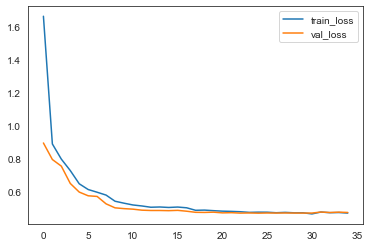

In [15]:
_ = log.plot()

In [73]:
surv = model_0a.predict_surv_df(x_test)

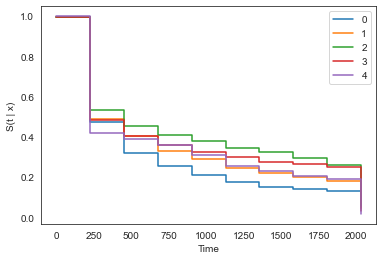

In [74]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [75]:
surv = model_0a.interpolate(10).predict_surv_df(x_test)

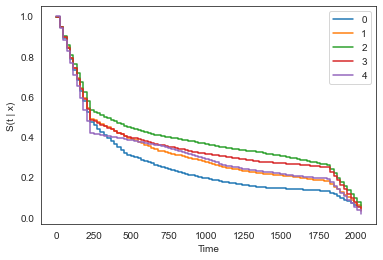

In [76]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [77]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [78]:
ev.concordance_td('antolini')

0.5514218218475047

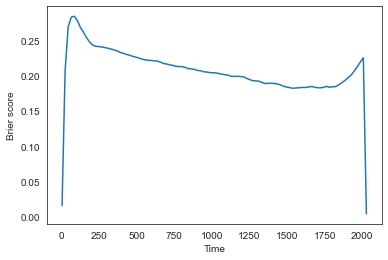

In [79]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

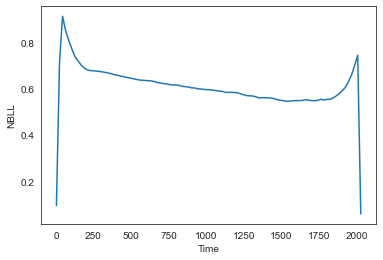

In [80]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [81]:
ev.integrated_brier_score(time_grid)

0.2098340600210912

In [82]:
ev.integrated_nbll(time_grid)

0.6133204185384793

## 1 layer 64 nodes

In [83]:
in_features = x_train.shape[1]
out_features = labtrans.out_features
num_nodes = [64]
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [84]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_0b = DeepHitSingle(net, optimizer, alpha = 0.2, sigma = 0.1, duration_index=labtrans.cuts)

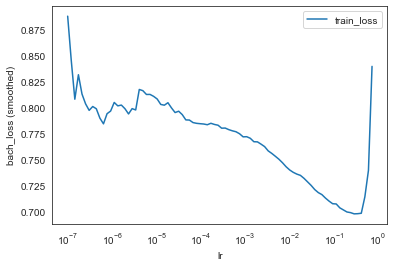

In [85]:
batch_size = 256
lr_finder = model_0b.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [86]:
lr_finder.get_best_lr()

0.029150530628251937

In [87]:
model_0b.optimizer.set_lr(0.03)

In [88]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model_0b.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.8372,	val_loss: 0.6879
1:	[0s / 1s],		train_loss: 0.6720,	val_loss: 0.5991
2:	[0s / 1s],		train_loss: 0.5990,	val_loss: 0.5737
3:	[0s / 2s],		train_loss: 0.5800,	val_loss: 0.5394
4:	[0s / 2s],		train_loss: 0.5385,	val_loss: 0.5292
5:	[0s / 3s],		train_loss: 0.5204,	val_loss: 0.4991
6:	[0s / 4s],		train_loss: 0.5140,	val_loss: 0.4966
7:	[0s / 4s],		train_loss: 0.5126,	val_loss: 0.5023
8:	[0s / 5s],		train_loss: 0.5051,	val_loss: 0.4881
9:	[0s / 6s],		train_loss: 0.4913,	val_loss: 0.4796
10:	[0s / 6s],		train_loss: 0.4807,	val_loss: 0.4752
11:	[0s / 7s],		train_loss: 0.4702,	val_loss: 0.4705
12:	[0s / 7s],		train_loss: 0.4740,	val_loss: 0.4688
13:	[0s / 8s],		train_loss: 0.4714,	val_loss: 0.4684
14:	[0s / 9s],		train_loss: 0.4648,	val_loss: 0.4684
15:	[0s / 10s],		train_loss: 0.4735,	val_loss: 0.4759
16:	[0s / 10s],		train_loss: 0.4747,	val_loss: 0.4769
17:	[0s / 11s],		train_loss: 0.4712,	val_loss: 0.4751
18:	[0s / 11s],		train_loss: 0.4751,	val_loss: 0.4792

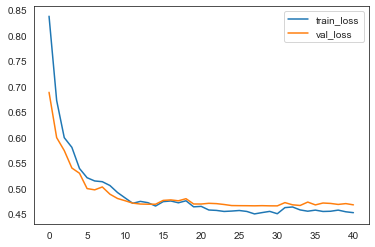

In [89]:
_ = log.plot()

In [90]:
surv = model_0b.predict_surv_df(x_test)

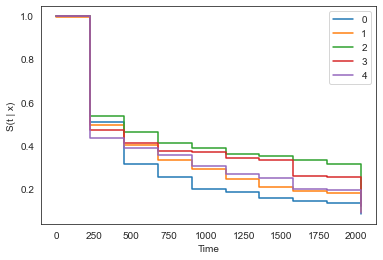

In [91]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [92]:
surv = model_0b.interpolate(10).predict_surv_df(x_test)

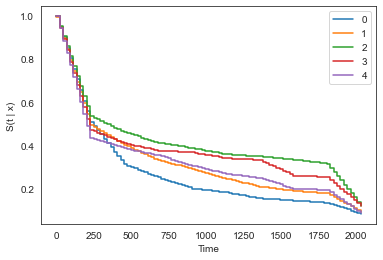

In [93]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [94]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [95]:
ev.concordance_td('antolini')

0.5521660251163136

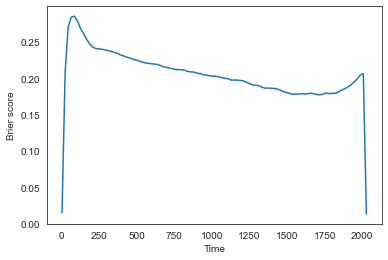

In [96]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

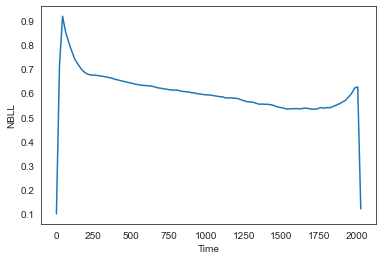

In [97]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [98]:
ev.integrated_brier_score(time_grid)

0.20679701307873702

In [99]:
ev.integrated_nbll(time_grid)

0.604551435939566

### 2 layers 32 nodes

In [210]:
in_features = x_train.shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [211]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_1a = DeepHitSingle(net, optimizer, alpha = 0.2, sigma = 0.1, duration_index=labtrans.cuts)

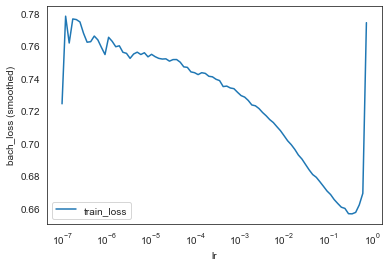

In [212]:
batch_size = 256
lr_finder = model_1a.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [213]:
lr_finder.get_best_lr()

0.035111917342151515

In [214]:
model_1a.optimizer.set_lr(0.04)

In [215]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model_1a.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.5963,	val_loss: 0.5305
1:	[0s / 0s],		train_loss: 0.5192,	val_loss: 0.4750
2:	[0s / 1s],		train_loss: 0.4803,	val_loss: 0.4708
3:	[0s / 1s],		train_loss: 0.4768,	val_loss: 0.4667
4:	[0s / 2s],		train_loss: 0.4659,	val_loss: 0.4623
5:	[0s / 2s],		train_loss: 0.4641,	val_loss: 0.4598
6:	[0s / 3s],		train_loss: 0.4583,	val_loss: 0.4591
7:	[0s / 3s],		train_loss: 0.4632,	val_loss: 0.4619
8:	[0s / 4s],		train_loss: 0.4636,	val_loss: 0.4609
9:	[0s / 4s],		train_loss: 0.4609,	val_loss: 0.4616
10:	[0s / 5s],		train_loss: 0.4610,	val_loss: 0.4591
11:	[0s / 6s],		train_loss: 0.4578,	val_loss: 0.4575
12:	[0s / 6s],		train_loss: 0.4501,	val_loss: 0.4574
13:	[0s / 7s],		train_loss: 0.4584,	val_loss: 0.4571
14:	[0s / 8s],		train_loss: 0.4495,	val_loss: 0.4573
15:	[0s / 8s],		train_loss: 0.4584,	val_loss: 0.4596
16:	[0s / 9s],		train_loss: 0.4604,	val_loss: 0.4598
17:	[0s / 9s],		train_loss: 0.4589,	val_loss: 0.4619
18:	[0s / 10s],		train_loss: 0.4561,	val_loss: 0.4590
19

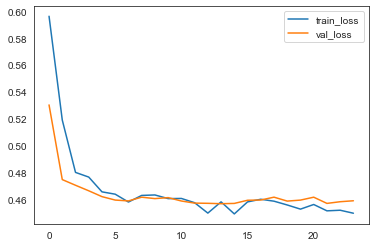

In [216]:
_ = log.plot()

In [217]:
surv = model_1a.predict_surv_df(x_test)

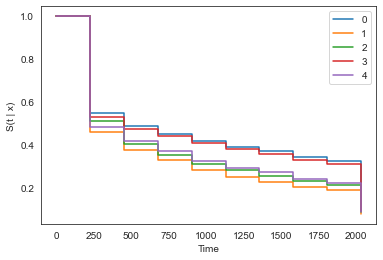

In [218]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [219]:
surv = model_1a.interpolate(10).predict_surv_df(x_test)

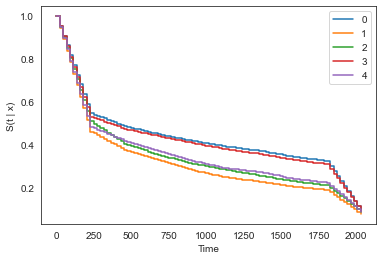

In [220]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [221]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [222]:
ev.concordance_td('antolini')

0.5335527059628535

In [223]:
ev.concordance_td()

0.5332633957509281

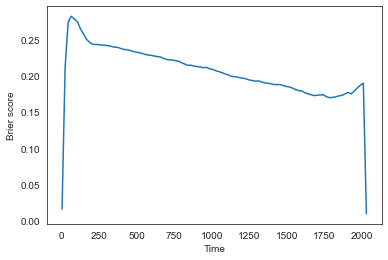

In [224]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

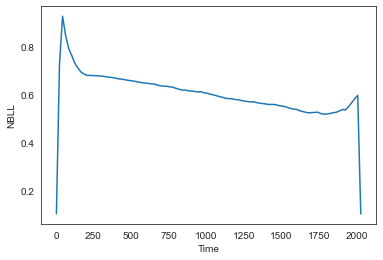

In [225]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [226]:
ev.integrated_brier_score(time_grid)

0.2076155276284153

In [227]:
ev.integrated_nbll(time_grid)

0.6065925190530013

### 2 layers 64 nodes

In [228]:
in_features = x_train.shape[1]
out_features = labtrans.out_features
num_nodes = [64, 64]
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [229]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_1b = DeepHitSingle(net, optimizer, alpha = 0.2, sigma = 0.1, duration_index=labtrans.cuts)

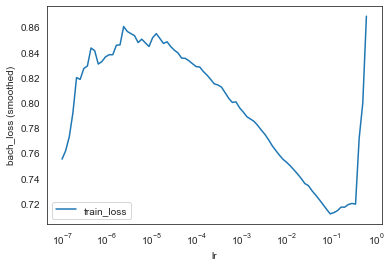

In [230]:
batch_size = 256
lr_finder = model_1b.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [231]:
lr_finder.get_best_lr()

0.009545484566618393

In [232]:
model_1b.optimizer.set_lr(0.01)

In [233]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model_1b.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.6591,	val_loss: 0.5881
1:	[0s / 1s],		train_loss: 0.5792,	val_loss: 0.5371
2:	[0s / 1s],		train_loss: 0.5390,	val_loss: 0.5262
3:	[0s / 1s],		train_loss: 0.5297,	val_loss: 0.5055
4:	[0s / 2s],		train_loss: 0.5082,	val_loss: 0.4873
5:	[0s / 2s],		train_loss: 0.4920,	val_loss: 0.4816
6:	[0s / 3s],		train_loss: 0.4891,	val_loss: 0.4820
7:	[0s / 4s],		train_loss: 0.4953,	val_loss: 0.4766
8:	[0s / 5s],		train_loss: 0.4870,	val_loss: 0.4730
9:	[0s / 5s],		train_loss: 0.4729,	val_loss: 0.4655
10:	[0s / 6s],		train_loss: 0.4690,	val_loss: 0.4642
11:	[1s / 7s],		train_loss: 0.4685,	val_loss: 0.4609
12:	[0s / 8s],		train_loss: 0.4627,	val_loss: 0.4602
13:	[0s / 8s],		train_loss: 0.4627,	val_loss: 0.4596
14:	[0s / 9s],		train_loss: 0.4561,	val_loss: 0.4597
15:	[0s / 10s],		train_loss: 0.4594,	val_loss: 0.4617
16:	[0s / 11s],		train_loss: 0.4619,	val_loss: 0.4594
17:	[0s / 11s],		train_loss: 0.4604,	val_loss: 0.4588
18:	[0s / 12s],		train_loss: 0.4562,	val_loss: 0.4596

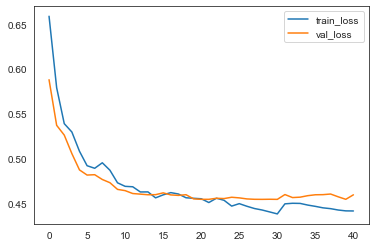

In [234]:
_ = log.plot()

In [235]:
surv = model_1b.predict_surv_df(x_test)

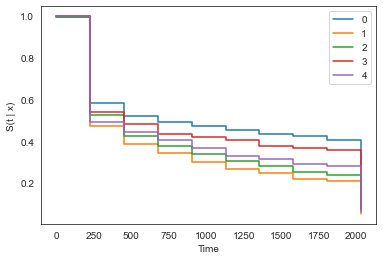

In [236]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [237]:
surv = model_1b.interpolate(10).predict_surv_df(x_test)

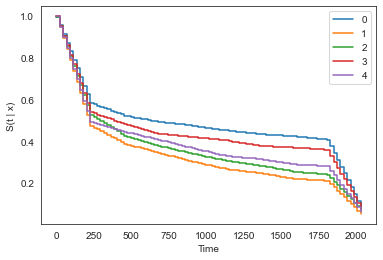

In [238]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [239]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [240]:
ev.concordance_td('antolini')

0.5378939052879963

In [242]:
ev.concordance_td()

0.5375644115676373

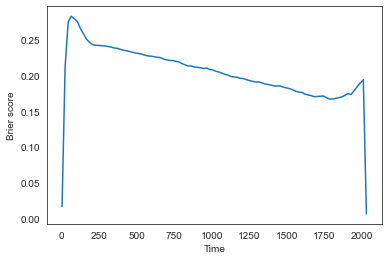

In [243]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

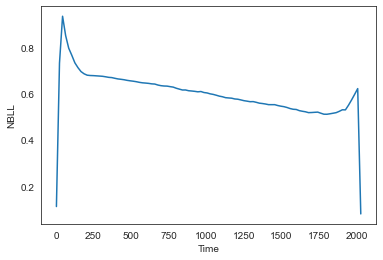

In [244]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [245]:
ev.integrated_brier_score(time_grid)

0.2064863356275589

In [246]:
ev.integrated_nbll(time_grid)

0.604317262507465

### 2 layers 128 nodes

In [302]:
in_features = x_train.shape[1]
out_features = labtrans.out_features
num_nodes = [128, 128]
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [303]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_1b2 = DeepHitSingle(net, optimizer, alpha = 0.2, sigma = 0.1, duration_index=labtrans.cuts)

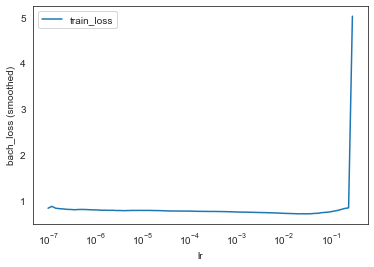

In [304]:
batch_size = 256
lr_finder = model_1b2.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [305]:
lr_finder.get_best_lr()

0.002154434690031894

In [307]:
model_1b2.optimizer.set_lr(0.002)

In [308]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model_1b2.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.6790,	val_loss: 0.6104
1:	[0s / 1s],		train_loss: 0.6220,	val_loss: 0.5831
2:	[0s / 2s],		train_loss: 0.5965,	val_loss: 0.5803
3:	[0s / 3s],		train_loss: 0.5919,	val_loss: 0.5658
4:	[2s / 5s],		train_loss: 0.5652,	val_loss: 0.5549
5:	[0s / 6s],		train_loss: 0.5576,	val_loss: 0.5509
6:	[0s / 7s],		train_loss: 0.5574,	val_loss: 0.5501
7:	[1s / 8s],		train_loss: 0.5488,	val_loss: 0.5388
8:	[0s / 9s],		train_loss: 0.5512,	val_loss: 0.5314
9:	[0s / 10s],		train_loss: 0.5383,	val_loss: 0.5292
10:	[0s / 11s],		train_loss: 0.5323,	val_loss: 0.5229
11:	[1s / 12s],		train_loss: 0.5251,	val_loss: 0.5197
12:	[1s / 13s],		train_loss: 0.5207,	val_loss: 0.5183
13:	[0s / 14s],		train_loss: 0.5180,	val_loss: 0.5176
14:	[1s / 15s],		train_loss: 0.5147,	val_loss: 0.5173
15:	[0s / 16s],		train_loss: 0.5237,	val_loss: 0.5141
16:	[1s / 18s],		train_loss: 0.5126,	val_loss: 0.5094
17:	[0s / 18s],		train_loss: 0.5099,	val_loss: 0.5079
18:	[0s / 19s],		train_loss: 0.5036,	val_loss: 

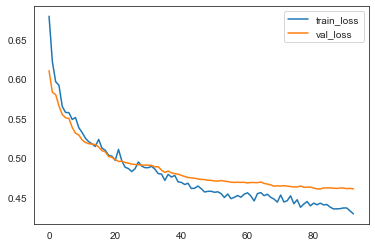

In [309]:
_ = log.plot()

In [310]:
surv = model_1b2.predict_surv_df(x_test)

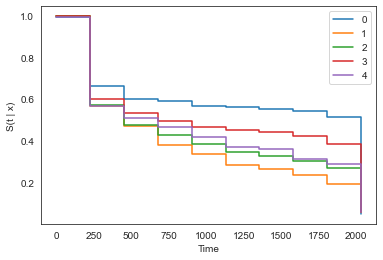

In [311]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [312]:
surv = model_1b2.interpolate(10).predict_surv_df(x_test)

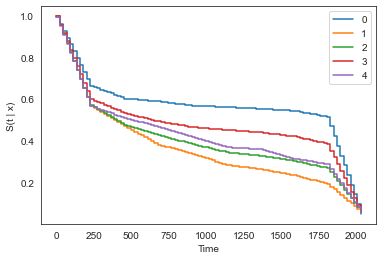

In [313]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [314]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [315]:
ev.concordance_td('antolini')

0.5545979416562781

In [316]:
ev.concordance_td()

0.5541159019001731

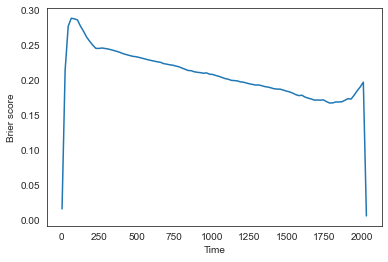

In [317]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

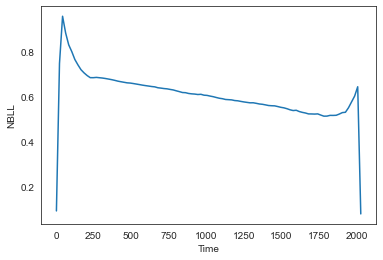

In [318]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [319]:
ev.integrated_brier_score(time_grid)

0.2084995838686117

In [320]:
ev.integrated_nbll(time_grid)

0.6111797858606703

### 3 layers 32 nodes

In [248]:
in_features = x_train.shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [249]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_1c = DeepHitSingle(net, optimizer, alpha = 0.2, sigma = 0.1, duration_index=labtrans.cuts)

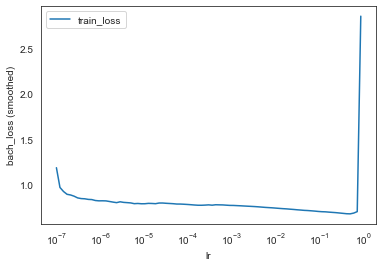

In [250]:
batch_size = 256
lr_finder = model_1c.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [251]:
lr_finder.get_best_lr()

0.050941380148164093

In [252]:
model_1c.optimizer.set_lr(0.05)

In [253]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model_1c.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.6702,	val_loss: 0.5796
1:	[1s / 1s],		train_loss: 0.5460,	val_loss: 0.4826
2:	[0s / 2s],		train_loss: 0.4953,	val_loss: 0.4798
3:	[0s / 2s],		train_loss: 0.4866,	val_loss: 0.4735
4:	[0s / 3s],		train_loss: 0.4747,	val_loss: 0.4652
5:	[0s / 3s],		train_loss: 0.4680,	val_loss: 0.4620
6:	[0s / 4s],		train_loss: 0.4679,	val_loss: 0.4611
7:	[0s / 5s],		train_loss: 0.4638,	val_loss: 0.4646
8:	[0s / 5s],		train_loss: 0.4704,	val_loss: 0.4607
9:	[0s / 6s],		train_loss: 0.4681,	val_loss: 0.4564
10:	[0s / 7s],		train_loss: 0.4691,	val_loss: 0.4576
11:	[0s / 7s],		train_loss: 0.4598,	val_loss: 0.4567
12:	[0s / 8s],		train_loss: 0.4611,	val_loss: 0.4537
13:	[0s / 9s],		train_loss: 0.4561,	val_loss: 0.4538
14:	[0s / 9s],		train_loss: 0.4564,	val_loss: 0.4539
15:	[0s / 10s],		train_loss: 0.4624,	val_loss: 0.4554
16:	[0s / 11s],		train_loss: 0.4644,	val_loss: 0.4574
17:	[0s / 11s],		train_loss: 0.4610,	val_loss: 0.4577
18:	[0s / 12s],		train_loss: 0.4533,	val_loss: 0.4537

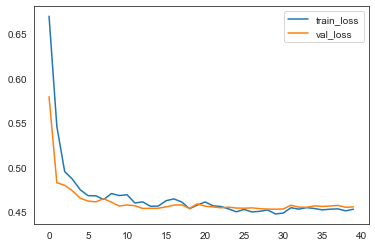

In [254]:
_ = log.plot()

In [255]:
surv = model_1c.predict_surv_df(x_test)

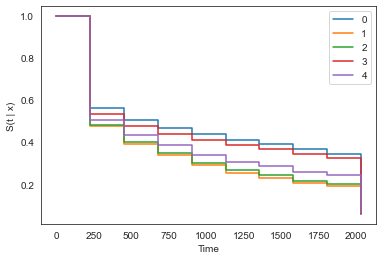

In [256]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [257]:
surv = model_1c.interpolate(10).predict_surv_df(x_test)

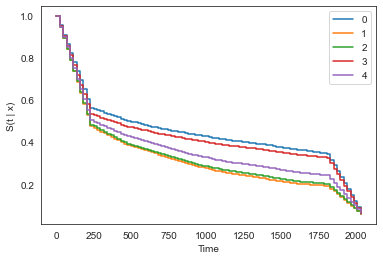

In [258]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [259]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [260]:
ev.concordance_td('antolini')

0.5329080969644643

In [261]:
ev.concordance_td()

0.5326330117514053

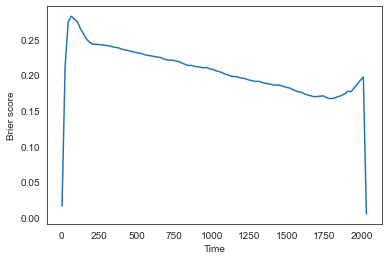

In [262]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

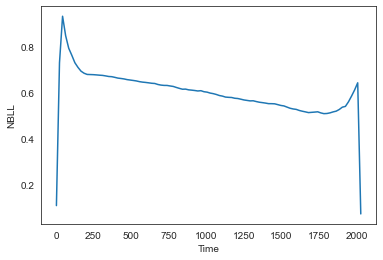

In [263]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [264]:
ev.integrated_brier_score(time_grid)

0.20673337430613187

In [265]:
ev.integrated_nbll(time_grid)

0.6048967357294565

### 3 layers 64 nodes

In [266]:
in_features = x_train.shape[1]
out_features = labtrans.out_features
num_nodes = [64, 64, 64]
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [267]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_1d = DeepHitSingle(net, optimizer, alpha = 0.2, sigma = 0.1, duration_index=labtrans.cuts)

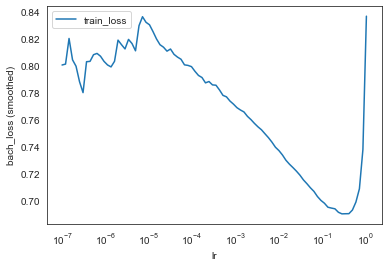

In [268]:
batch_size = 256
lr_finder = model_1d.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [269]:
lr_finder.get_best_lr()

0.029150530628251937

In [270]:
model_1d.optimizer.set_lr(0.03)

In [271]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model_1d.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.7638,	val_loss: 0.6919
1:	[0s / 1s],		train_loss: 0.6428,	val_loss: 0.5672
2:	[0s / 2s],		train_loss: 0.5956,	val_loss: 0.5604
3:	[0s / 2s],		train_loss: 0.5764,	val_loss: 0.5316
4:	[0s / 3s],		train_loss: 0.6402,	val_loss: 0.5966
5:	[0s / 4s],		train_loss: 0.5894,	val_loss: 0.5447
6:	[0s / 4s],		train_loss: 0.5632,	val_loss: 0.5387
7:	[0s / 5s],		train_loss: 0.5354,	val_loss: 0.4983
8:	[0s / 6s],		train_loss: 0.5342,	val_loss: 0.5200
9:	[0s / 6s],		train_loss: 0.5259,	val_loss: 0.4816
10:	[0s / 7s],		train_loss: 0.4951,	val_loss: 0.4665
11:	[0s / 8s],		train_loss: 0.4792,	val_loss: 0.4611
12:	[0s / 8s],		train_loss: 0.4689,	val_loss: 0.4595
13:	[0s / 9s],		train_loss: 0.4687,	val_loss: 0.4614
14:	[0s / 9s],		train_loss: 0.4676,	val_loss: 0.4598
15:	[0s / 10s],		train_loss: 0.4643,	val_loss: 0.4588
16:	[0s / 11s],		train_loss: 0.4637,	val_loss: 0.4621
17:	[0s / 11s],		train_loss: 0.4673,	val_loss: 0.4582
18:	[0s / 12s],		train_loss: 0.4622,	val_loss: 0.4618

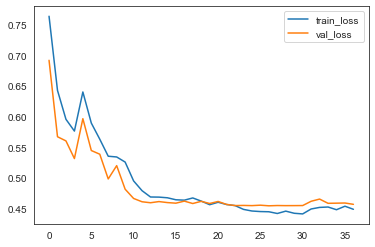

In [272]:
_ = log.plot()

In [273]:
surv = model_1d.predict_surv_df(x_test)

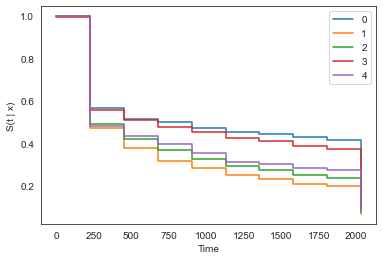

In [274]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [275]:
surv = model_1d.interpolate(10).predict_surv_df(x_test)

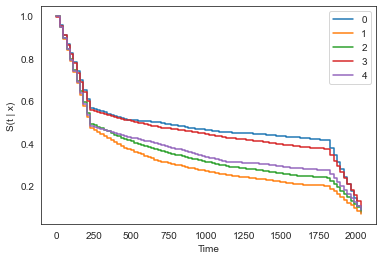

In [276]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [277]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [278]:
ev.concordance_td('antolini')

0.5360569898962312

In [279]:
ev.concordance_td()

0.5357438276567248

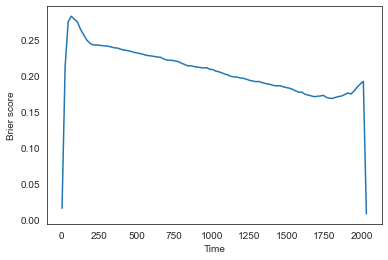

In [280]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

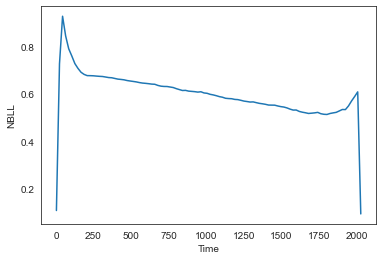

In [281]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [282]:
ev.integrated_brier_score(time_grid)

0.20666629428487898

In [283]:
ev.integrated_nbll(time_grid)

0.6046027235944758

### 4 layers 32 nodes

In [284]:
in_features = x_train.shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [285]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_1e = DeepHitSingle(net, optimizer, alpha = 0.2, sigma = 0.1, duration_index=labtrans.cuts)

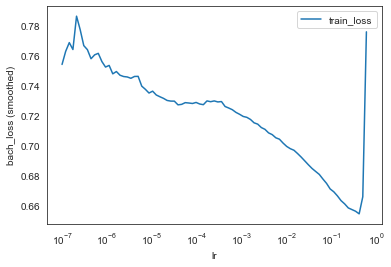

In [286]:
batch_size = 256
lr_finder = model_1e.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [287]:
lr_finder.get_best_lr()

0.04229242874389523

In [288]:
model_1e.optimizer.set_lr(0.04)

In [289]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model_1e.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.7483,	val_loss: 0.6671
1:	[0s / 1s],		train_loss: 0.6548,	val_loss: 0.5818
2:	[0s / 1s],		train_loss: 0.5801,	val_loss: 0.5481
3:	[0s / 2s],		train_loss: 0.5506,	val_loss: 0.5112
4:	[0s / 3s],		train_loss: 0.5197,	val_loss: 0.4889
5:	[0s / 3s],		train_loss: 0.4969,	val_loss: 0.4819
6:	[0s / 4s],		train_loss: 0.4963,	val_loss: 0.4800
7:	[0s / 5s],		train_loss: 0.4913,	val_loss: 0.4702
8:	[0s / 5s],		train_loss: 0.4818,	val_loss: 0.4682
9:	[0s / 6s],		train_loss: 0.4745,	val_loss: 0.4644
10:	[0s / 6s],		train_loss: 0.4658,	val_loss: 0.4621
11:	[0s / 7s],		train_loss: 0.4699,	val_loss: 0.4629
12:	[0s / 7s],		train_loss: 0.4654,	val_loss: 0.4606
13:	[0s / 8s],		train_loss: 0.4616,	val_loss: 0.4600
14:	[0s / 9s],		train_loss: 0.4611,	val_loss: 0.4605
15:	[0s / 9s],		train_loss: 0.4639,	val_loss: 0.4624
16:	[0s / 10s],		train_loss: 0.4661,	val_loss: 0.4640
17:	[0s / 10s],		train_loss: 0.4651,	val_loss: 0.4601
18:	[0s / 11s],		train_loss: 0.4620,	val_loss: 0.4589


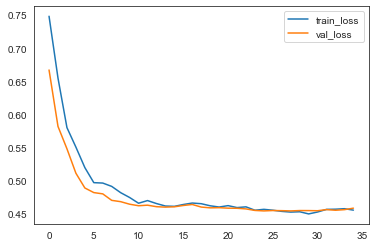

In [290]:
_ = log.plot()

In [291]:
surv = model_1e.predict_surv_df(x_test)

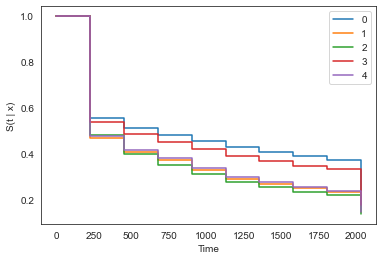

In [292]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [293]:
surv = model_1e.interpolate(10).predict_surv_df(x_test)

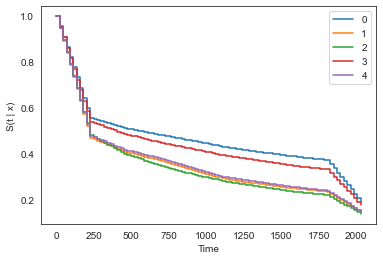

In [294]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [295]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [296]:
ev.concordance_td('antolini')

0.5584920260839049

In [297]:
ev.concordance_td()

0.5579822328470441

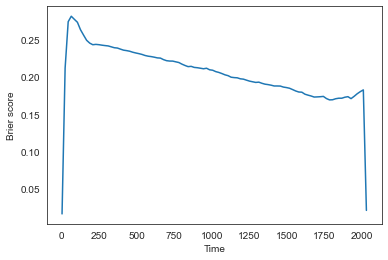

In [298]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

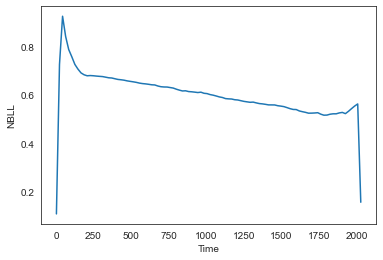

In [299]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [300]:
ev.integrated_brier_score(time_grid)

0.20739966401374813

In [301]:
ev.integrated_nbll(time_grid)

0.60574914939169

## With categorical embeddings

In [100]:
cols_std = ['age', 'mean_arterial_bp', 'hr', 'resp', 'temp', 'wbc', 'serum_na', 'serum_creat' ]
cols_ = ['sex', 'diab', 'dementia']
cols_cat = ['num_comorb', 'race', 'cancer']

standardize = [([col], StandardScaler()) for col in cols_std]
leave = [(col, None) for col in cols_]
categorical = [(col, OrderedCategoricalLong()) for col in cols_cat]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [101]:
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

In [102]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

In [98]:
x_train.types()

(numpy.ndarray, numpy.ndarray)

In [99]:
x_train.shapes()

((5678, 11), (5678, 3))

In [11]:
x_train.dtypes()

(dtype('float32'), dtype('int64'))

In [24]:
num_durations = 10

labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

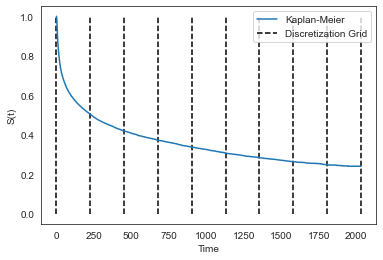

In [25]:
from pycox.utils import kaplan_meier
plt.vlines(labtrans.cuts, 0, 1, colors='black', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

In [104]:
train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

In [105]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [16]:
num_embeddings, embedding_dims

(array([7, 8, 4], dtype=int64), array([3, 4, 2], dtype=int64))

## 2 layers 32 nodes

In [108]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [109]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_2a = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts)

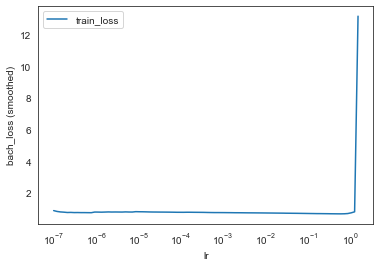

In [110]:
batch_size = 256
lrfind = model_2a.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [111]:
lrfind.get_best_lr()

0.0613590727341321

In [112]:
model_2a.optimizer.set_lr(0.06)

In [113]:
epochs = 100
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True # set to True if you want printout

In [114]:
%%time
log = model_2a.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 0.9649,	val_loss: 0.6618
1:	[0s / 1s],		train_loss: 0.6350,	val_loss: 0.5635
2:	[0s / 1s],		train_loss: 0.5808,	val_loss: 0.5482
3:	[0s / 2s],		train_loss: 0.5655,	val_loss: 0.5155
4:	[0s / 3s],		train_loss: 0.5335,	val_loss: 0.5076
5:	[0s / 3s],		train_loss: 0.5156,	val_loss: 0.4958
6:	[0s / 4s],		train_loss: 0.5068,	val_loss: 0.4951
7:	[0s / 5s],		train_loss: 0.5051,	val_loss: 0.4838
8:	[1s / 6s],		train_loss: 0.4953,	val_loss: 0.4787
9:	[0s / 7s],		train_loss: 0.4838,	val_loss: 0.4750
10:	[0s / 8s],		train_loss: 0.4758,	val_loss: 0.4718
11:	[0s / 9s],		train_loss: 0.4753,	val_loss: 0.4690
12:	[0s / 9s],		train_loss: 0.4721,	val_loss: 0.4692
13:	[0s / 10s],		train_loss: 0.4669,	val_loss: 0.4682
14:	[0s / 11s],		train_loss: 0.4705,	val_loss: 0.4683
15:	[0s / 11s],		train_loss: 0.4741,	val_loss: 0.4716
16:	[0s / 12s],		train_loss: 0.4710,	val_loss: 0.4664
17:	[0s / 12s],		train_loss: 0.4698,	val_loss: 0.4733
18:	[0s / 13s],		train_loss: 0.4711,	val_loss: 0.47

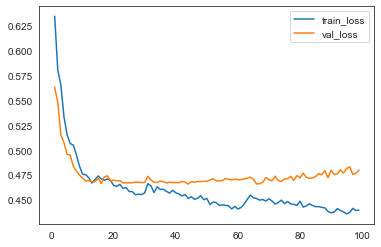

In [115]:
# used best learing rate
_ = log.to_pandas().iloc[1:].plot()

In [116]:
surv = model_2a.interpolate(10).predict_surv_df(x_test)

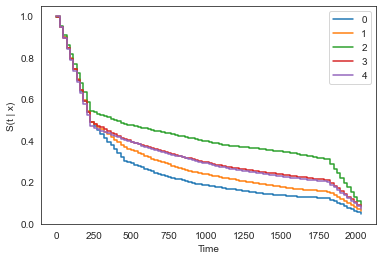

In [117]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [118]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [119]:
ev.concordance_td('antolini')

0.5585292910680301

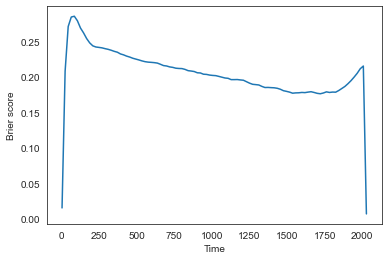

In [120]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

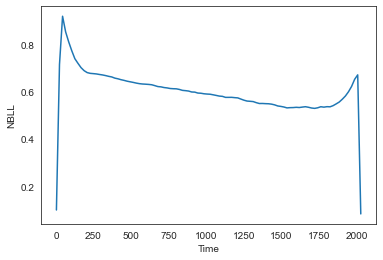

In [121]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [122]:
ev.integrated_brier_score(time_grid) 

0.20657558722907512

In [123]:
ev.integrated_nbll(time_grid) 

0.6044352985531316

## 2 layers 64 nodes

In [124]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [64, 64]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [125]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_2b = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts)

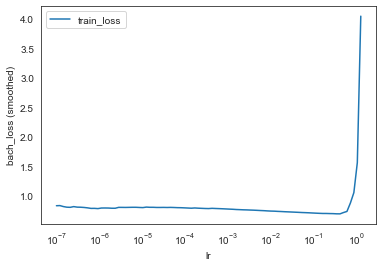

In [126]:
batch_size = 256
lrfind = model_2b.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [127]:
lrfind.get_best_lr()

0.04229242874389523

In [128]:
model_2b.optimizer.set_lr(0.04)

In [129]:
epochs = 100
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True # set to True if you want printout

In [130]:
%%time
log = model_2b.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 1.0229,	val_loss: 0.7898
1:	[0s / 1s],		train_loss: 0.7453,	val_loss: 0.6317
2:	[0s / 1s],		train_loss: 0.6525,	val_loss: 0.5990
3:	[0s / 2s],		train_loss: 0.6088,	val_loss: 0.5757
4:	[0s / 3s],		train_loss: 0.5790,	val_loss: 0.5312
5:	[0s / 3s],		train_loss: 0.5573,	val_loss: 0.5210
6:	[0s / 4s],		train_loss: 0.5316,	val_loss: 0.5129
7:	[0s / 4s],		train_loss: 0.5212,	val_loss: 0.4945
8:	[0s / 5s],		train_loss: 0.5156,	val_loss: 0.4907
9:	[0s / 6s],		train_loss: 0.4995,	val_loss: 0.4765
10:	[0s / 6s],		train_loss: 0.4837,	val_loss: 0.4744
11:	[0s / 7s],		train_loss: 0.4798,	val_loss: 0.4702
12:	[0s / 7s],		train_loss: 0.4740,	val_loss: 0.4704
13:	[0s / 8s],		train_loss: 0.4722,	val_loss: 0.4690
14:	[0s / 9s],		train_loss: 0.4699,	val_loss: 0.4687
15:	[0s / 9s],		train_loss: 0.4772,	val_loss: 0.4680
16:	[0s / 10s],		train_loss: 0.4736,	val_loss: 0.4761
17:	[0s / 10s],		train_loss: 0.4727,	val_loss: 0.4765
18:	[0s / 11s],		train_loss: 0.4687,	val_loss: 0.4683


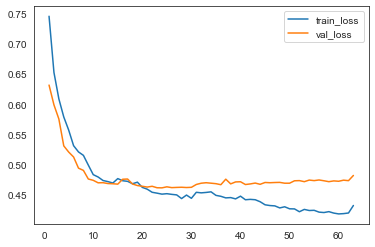

In [131]:
# used best learing rate
_ = log.to_pandas().iloc[1:].plot()

In [132]:
surv = model_2b.interpolate(10).predict_surv_df(x_test)

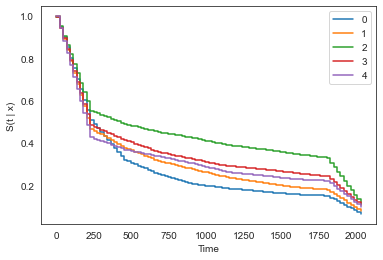

In [133]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [134]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [135]:
ev.concordance_td('antolini')

0.5416363870935764

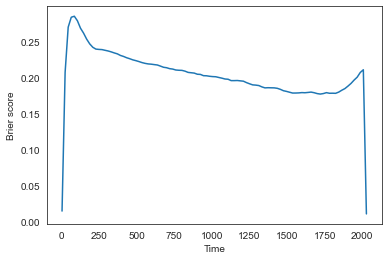

In [136]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

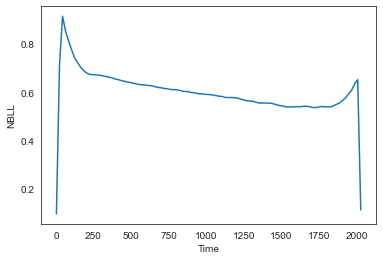

In [137]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [138]:
ev.integrated_brier_score(time_grid) 

0.20643107876735708

In [139]:
ev.integrated_nbll(time_grid) 

0.6046892344040887

## 3 layers 32 nodes

In [140]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [141]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_2c = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts)

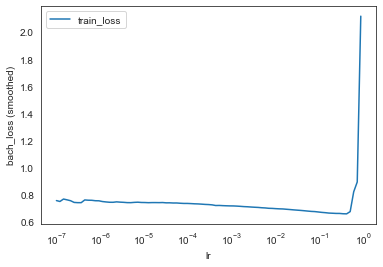

In [142]:
batch_size = 256
lrfind = model_2c.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [143]:
lrfind.get_best_lr()

0.04229242874389523

In [144]:
model_2c.optimizer.set_lr(0.04)

In [145]:
epochs = 100
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True # set to True if you want printout

In [146]:
%%time
log = model_2c.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 0.6572,	val_loss: 0.5702
1:	[0s / 1s],		train_loss: 0.5463,	val_loss: 0.4910
2:	[0s / 1s],		train_loss: 0.5035,	val_loss: 0.4822
3:	[0s / 2s],		train_loss: 0.4980,	val_loss: 0.4711
4:	[1s / 4s],		train_loss: 0.4805,	val_loss: 0.4710
5:	[0s / 5s],		train_loss: 0.4721,	val_loss: 0.4680
6:	[0s / 6s],		train_loss: 0.4726,	val_loss: 0.4672
7:	[0s / 6s],		train_loss: 0.4706,	val_loss: 0.4683
8:	[0s / 7s],		train_loss: 0.4763,	val_loss: 0.4696
9:	[1s / 8s],		train_loss: 0.4685,	val_loss: 0.4669
10:	[0s / 9s],		train_loss: 0.4657,	val_loss: 0.4654
11:	[0s / 9s],		train_loss: 0.4617,	val_loss: 0.4651
12:	[0s / 10s],		train_loss: 0.4616,	val_loss: 0.4651
13:	[0s / 10s],		train_loss: 0.4614,	val_loss: 0.4641
14:	[0s / 11s],		train_loss: 0.4584,	val_loss: 0.4642
15:	[0s / 12s],		train_loss: 0.4670,	val_loss: 0.4685
16:	[0s / 13s],		train_loss: 0.4621,	val_loss: 0.4658
17:	[0s / 13s],		train_loss: 0.4611,	val_loss: 0.4657
18:	[0s / 14s],		train_loss: 0.4590,	val_loss: 0.4

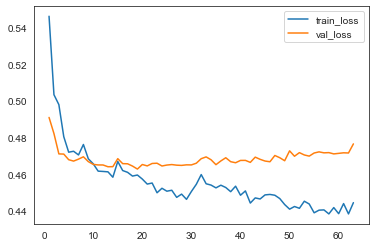

In [147]:
# used best learing rate
_ = log.to_pandas().iloc[1:].plot()

In [148]:
surv = model_2c.interpolate(10).predict_surv_df(x_test)

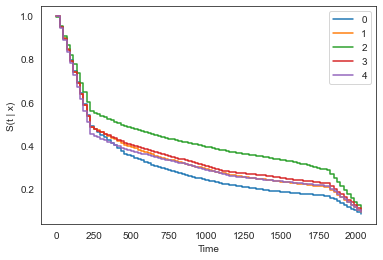

In [149]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [150]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [151]:
ev.concordance_td('antolini')

0.5355435417223968

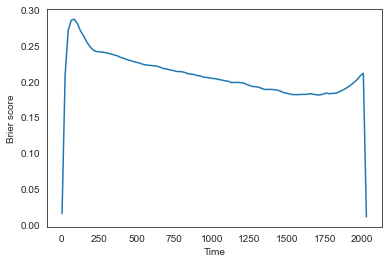

In [152]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

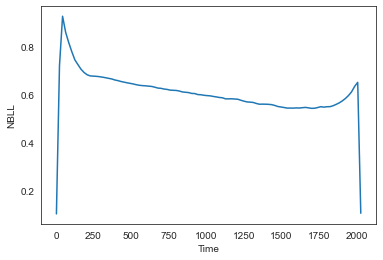

In [153]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [154]:
ev.integrated_brier_score(time_grid) 

0.20876324226355522

In [155]:
ev.integrated_nbll(time_grid) 

0.6099494930826811

## 3 layers 64 nodes

In [156]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [64, 64, 64]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [157]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_2d = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts)

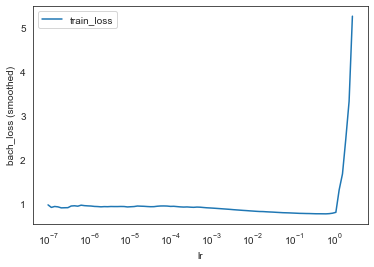

In [158]:
batch_size = 256
lrfind = model_2d.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [159]:
lrfind.get_best_lr()

0.0613590727341321

In [160]:
model_2d.optimizer.set_lr(0.06)

In [161]:
epochs = 100
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True # set to True if you want printout

In [162]:
%%time
log = model_2d.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 2.0758,	val_loss: 0.8334
1:	[1s / 1s],		train_loss: 1.1389,	val_loss: 0.9771
2:	[0s / 2s],		train_loss: 1.0054,	val_loss: 0.9085
3:	[0s / 3s],		train_loss: 0.9352,	val_loss: 0.7810
4:	[0s / 3s],		train_loss: 0.7985,	val_loss: 0.6883
5:	[0s / 4s],		train_loss: 0.7395,	val_loss: 0.6736
6:	[0s / 5s],		train_loss: 0.7241,	val_loss: 0.6654
7:	[0s / 6s],		train_loss: 0.6920,	val_loss: 0.6013
8:	[0s / 6s],		train_loss: 0.6543,	val_loss: 0.6117
9:	[0s / 7s],		train_loss: 0.6232,	val_loss: 0.5716
10:	[0s / 8s],		train_loss: 0.5994,	val_loss: 0.5501
11:	[0s / 9s],		train_loss: 0.5788,	val_loss: 0.5367
12:	[0s / 9s],		train_loss: 0.5925,	val_loss: 0.6022
13:	[1s / 11s],		train_loss: 0.6008,	val_loss: 0.5764
14:	[0s / 11s],		train_loss: 0.5903,	val_loss: 0.5784
15:	[0s / 12s],		train_loss: 0.5661,	val_loss: 0.5257
16:	[0s / 13s],		train_loss: 0.5411,	val_loss: 0.4970
17:	[0s / 14s],		train_loss: 0.5255,	val_loss: 0.4978
18:	[0s / 14s],		train_loss: 0.5141,	val_loss: 0.49

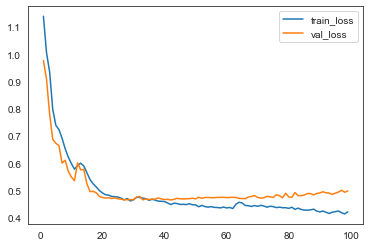

In [163]:
# used best learing rate
_ = log.to_pandas().iloc[1:].plot()

In [164]:
surv = model_2d.interpolate(10).predict_surv_df(x_test)

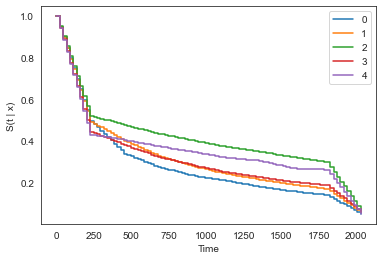

In [165]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [166]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [167]:
ev.concordance_td('antolini')

0.5759397115173656

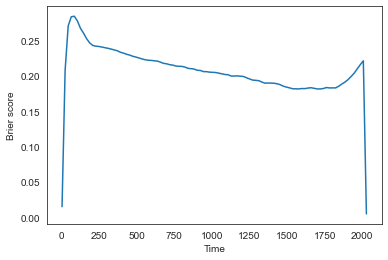

In [168]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

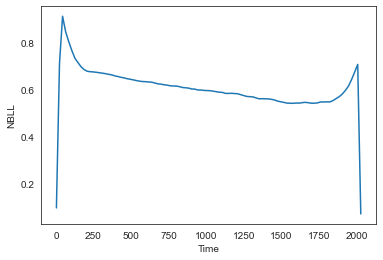

In [169]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [170]:
ev.integrated_brier_score(time_grid) 

0.20900082945757167

In [171]:
ev.integrated_nbll(time_grid) 

0.6108832610132867

## 4 layers 32 nodes

In [17]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [18]:
net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(7, 3)
      (1): Embedding(8, 4)
      (2): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=20, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [20]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_2e = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts)

C:\Users\Ryan\anaconda3\lib\site-packages\torchtuples\callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1005.)
  p.data = p.data.add(-weight_decay * eta, p.data)


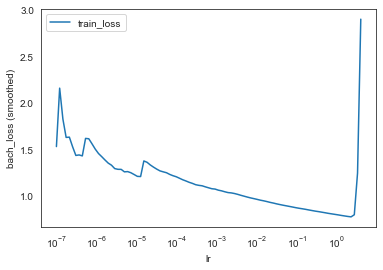

In [21]:
batch_size = 256
lrfind = model_2e.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [22]:
model_2e.optimizer.param_groups[0]['lr']

0.22570197196339348

In [23]:
lrfind.get_best_lr()

0.22570197196339348

In [28]:
model_2e.optimizer.set_lr(0.1)

In [25]:
epochs = 100
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True # set to True if you want printout

In [29]:
%%time
log = model_2e.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

16:	[0s / 0s],		train_loss: 1.5548,	val_loss: 1.0576
17:	[0s / 1s],		train_loss: 1.6411,	val_loss: 1.4198
18:	[0s / 1s],		train_loss: 1.2786,	val_loss: 0.8801
19:	[0s / 2s],		train_loss: 0.9337,	val_loss: 0.8185
20:	[0s / 3s],		train_loss: 0.9393,	val_loss: 0.7133
21:	[0s / 3s],		train_loss: 0.8412,	val_loss: 0.6961
22:	[0s / 4s],		train_loss: 0.7937,	val_loss: 0.6568
23:	[0s / 5s],		train_loss: 0.7572,	val_loss: 0.6513
24:	[0s / 6s],		train_loss: 0.7816,	val_loss: 0.6497
25:	[0s / 7s],		train_loss: 0.7547,	val_loss: 0.6678
26:	[0s / 7s],		train_loss: 0.7418,	val_loss: 0.6419
27:	[0s / 8s],		train_loss: 0.7286,	val_loss: 0.6405
28:	[0s / 8s],		train_loss: 0.7413,	val_loss: 0.6355
29:	[0s / 9s],		train_loss: 0.7303,	val_loss: 0.6351
30:	[0s / 10s],		train_loss: 0.7280,	val_loss: 0.6365
31:	[0s / 10s],		train_loss: 0.7054,	val_loss: 0.6165
32:	[0s / 11s],		train_loss: 1.3111,	val_loss: 0.6738
33:	[0s / 12s],		train_loss: 0.8532,	val_loss: 0.7778
34:	[0s / 13s],		train_loss: 0.7634,	val_l

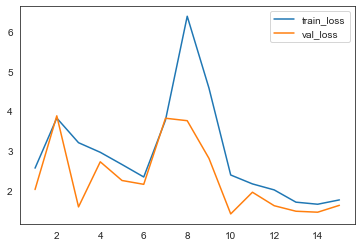

In [27]:
# used best learing rate
_ = log.to_pandas().iloc[1:].plot()

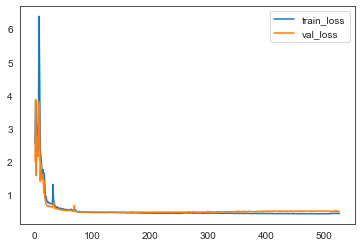

In [30]:
# used learning rate 0.1
_ = log.to_pandas().iloc[1:].plot()

In [31]:
surv = model_2e.interpolate(10).predict_surv_df(x_test)

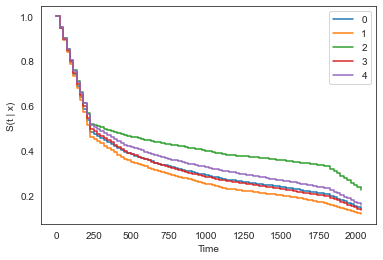

In [32]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [33]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [34]:
ev.concordance_td('antolini')

0.5362954016929934

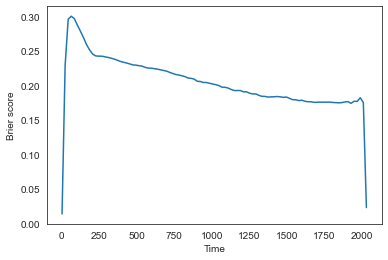

In [35]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

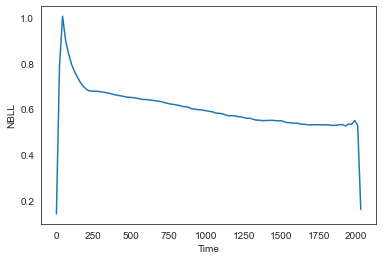

In [36]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [37]:
ev.integrated_brier_score(time_grid) 

0.20637700056748656

In [38]:
ev.integrated_nbll(time_grid) 

0.6044487271353028

## 4 layers 64 nodes

In [172]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [64, 64, 64, 64]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [173]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model_2f = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts)

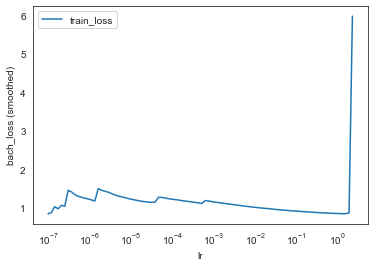

In [174]:
batch_size = 256
lrfind = model_2f.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [175]:
lrfind.get_best_lr()

0.0001

In [176]:
model_2f.optimizer.set_lr(0.001)

In [177]:
epochs = 100
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True # set to True if you want printout

In [178]:
%%time
log = model_2f.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 1.1343,	val_loss: 0.6210
1:	[1s / 2s],		train_loss: 0.7143,	val_loss: 0.6150
2:	[0s / 2s],		train_loss: 0.7005,	val_loss: 0.6111
3:	[0s / 3s],		train_loss: 0.6805,	val_loss: 0.6072
4:	[0s / 4s],		train_loss: 0.6688,	val_loss: 0.6019
5:	[0s / 5s],		train_loss: 0.6645,	val_loss: 0.6020
6:	[0s / 6s],		train_loss: 0.6559,	val_loss: 0.6015
7:	[1s / 7s],		train_loss: 0.6555,	val_loss: 0.5977
8:	[1s / 8s],		train_loss: 0.6437,	val_loss: 0.5957
9:	[1s / 10s],		train_loss: 0.6337,	val_loss: 0.5922
10:	[0s / 11s],		train_loss: 0.6361,	val_loss: 0.5900
11:	[1s / 12s],		train_loss: 0.6523,	val_loss: 0.5889
12:	[1s / 13s],		train_loss: 0.6233,	val_loss: 0.5884
13:	[1s / 14s],		train_loss: 0.6329,	val_loss: 0.5880
14:	[0s / 15s],		train_loss: 0.6225,	val_loss: 0.5882
15:	[0s / 16s],		train_loss: 0.6256,	val_loss: 0.5856
16:	[1s / 17s],		train_loss: 0.6241,	val_loss: 0.5820
17:	[1s / 18s],		train_loss: 0.6143,	val_loss: 0.5803
18:	[0s / 19s],		train_loss: 0.6117,	val_loss: 

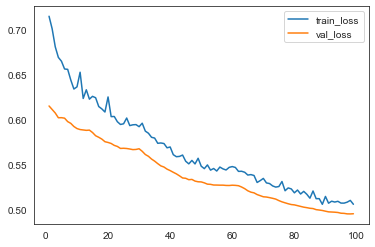

In [179]:
# used learning rate 0.1
_ = log.to_pandas().iloc[1:].plot()

In [180]:
surv = model_2f.interpolate(10).predict_surv_df(x_test)

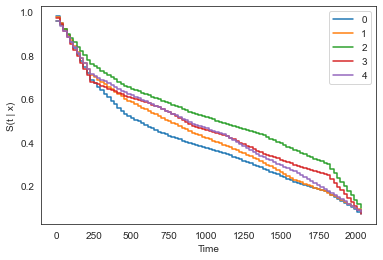

In [181]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [182]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [183]:
ev.concordance_td('antolini')

0.5344356191282836

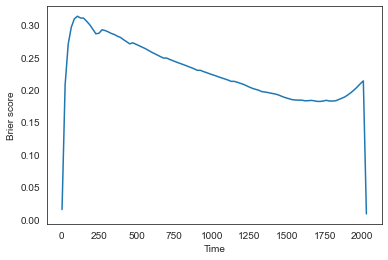

In [184]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

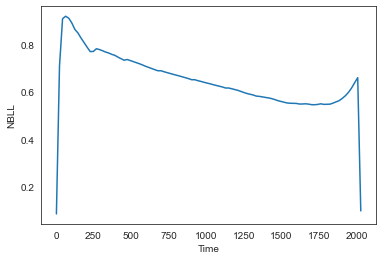

In [185]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [186]:
ev.integrated_brier_score(time_grid) 

0.22826353663473958

In [187]:
ev.integrated_nbll(time_grid) 

0.654874257640902

# Using a quantile discretization grid

In [26]:
num_durations = 10
scheme = 'quantiles'
labtrans = DeepHitSingle.label_transform(num_durations, scheme)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)

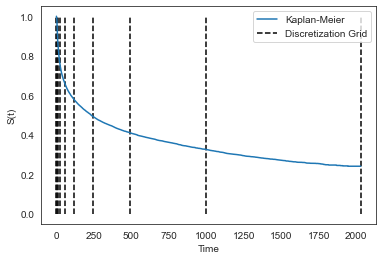

In [28]:
from pycox.utils import kaplan_meier
plt.vlines(labtrans.cuts, 0, 1, colors='black', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

In [194]:
train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

In [131]:
train.types()

((numpy.ndarray, numpy.ndarray), (numpy.ndarray, numpy.ndarray))

In [132]:
train.shapes()

(((5678, 11), (5678, 3)), ((5678,), (5678,)))

In [133]:
train.dtypes()

((dtype('float32'), dtype('int64')), (dtype('int64'), dtype('float32')))

In [195]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [114]:
num_embeddings, embedding_dims

(array([7, 8, 4], dtype=int64), array([3, 4, 2], dtype=int64))

In [196]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [64, 64]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [137]:
net


MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(7, 3)
      (1): Embedding(8, 4)
      (2): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=20, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [197]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model3 = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts)

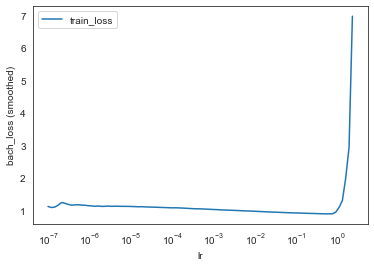

In [198]:
batch_size = 256
lrfind = model3.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [200]:
model3.optimizer.param_groups[0]['lr']

0.0613590727341321

In [199]:
lrfind.get_best_lr()

0.0613590727341321

In [201]:
model3.optimizer.set_lr(0.06)

In [202]:
epochs = 100
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = False # set to True if you want printout

In [203]:
%%time
log = model3.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

Wall time: 35.6 s


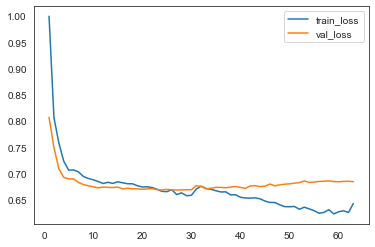

In [204]:
_ = log.to_pandas().iloc[1:].plot()

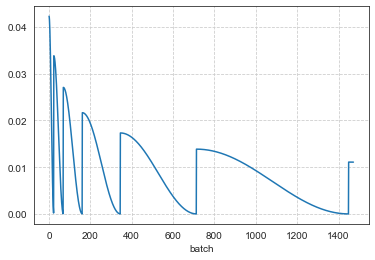

In [146]:
lrs = model3.optimizer.lr_scheduler.to_pandas() * model3.optimizer.param_groups[0]['initial_lr']
lrs.plot()
plt.grid(linestyle='--')

In [205]:
surv = model3.interpolate(10).predict_surv_df(x_test)

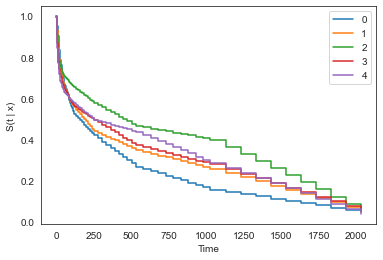

In [206]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [207]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [208]:
ev.concordance_td('antolini')

0.6514060047946808

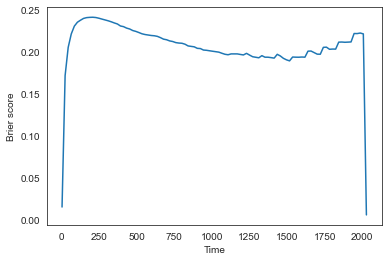

In [209]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

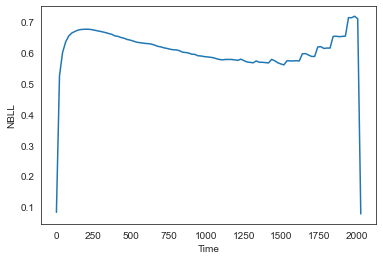

In [210]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [211]:
ev.integrated_brier_score(time_grid) 

0.2087905778939771

In [212]:
ev.integrated_nbll(time_grid) 

0.610637549276836

## 2 layers 64 nodes alpha = 0.5 (equidistant)

In [218]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [64, 64]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [219]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = DeepHitSingle(net, optimizer, alpha = 0.5, sigma = 0.1, duration_index=labtrans.cuts)

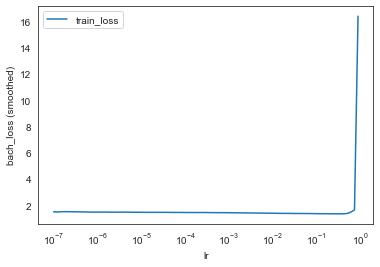

In [220]:
batch_size = 256
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [221]:
lrfind.get_best_lr()

0.035111917342151515

In [224]:
model.optimizer.set_lr(0.04)

In [225]:
epochs = 100
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True # set to True if you want printout

In [226]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 1.4022,	val_loss: 1.2061
1:	[0s / 1s],		train_loss: 1.2278,	val_loss: 1.1704
2:	[0s / 2s],		train_loss: 1.1682,	val_loss: 1.1450
3:	[0s / 3s],		train_loss: 1.1573,	val_loss: 1.1345
4:	[0s / 3s],		train_loss: 1.1407,	val_loss: 1.1309
5:	[0s / 4s],		train_loss: 1.1413,	val_loss: 1.1264
6:	[0s / 5s],		train_loss: 1.1297,	val_loss: 1.1251
7:	[0s / 6s],		train_loss: 1.1335,	val_loss: 1.1237
8:	[1s / 7s],		train_loss: 1.1391,	val_loss: 1.1340
9:	[0s / 8s],		train_loss: 1.1354,	val_loss: 1.1297
10:	[0s / 9s],		train_loss: 1.1214,	val_loss: 1.1244
11:	[0s / 10s],		train_loss: 1.1205,	val_loss: 1.1271
12:	[0s / 10s],		train_loss: 1.1194,	val_loss: 1.1235
13:	[1s / 12s],		train_loss: 1.1072,	val_loss: 1.1243
14:	[0s / 12s],		train_loss: 1.1099,	val_loss: 1.1237
15:	[0s / 13s],		train_loss: 1.1238,	val_loss: 1.1362
16:	[0s / 14s],		train_loss: 1.1247,	val_loss: 1.1323
17:	[0s / 15s],		train_loss: 1.1209,	val_loss: 1.1263
18:	[0s / 16s],		train_loss: 1.1139,	val_loss: 1.

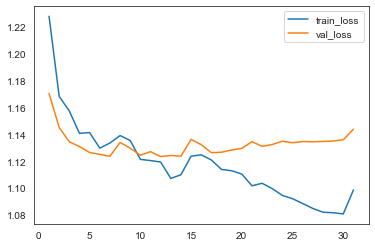

In [227]:
_ = log.to_pandas().iloc[1:].plot()

# DeepSurv

## 2 layers 32 nodes

In [37]:
cols_std = ['age', 'mean_arterial_bp', 'hr', 'resp', 'temp', 'wbc', 'serum_na', 'serum_creat', 'num_comorb', 'race', 'cancer' ]
cols_ = ['sex', 'diab', 'dementia']


standardize = [([col], StandardScaler()) for col in cols_std]
leave = [(col, None) for col in cols_]


x_mapper = DataFrameMapper(standardize + leave)


In [38]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')


In [39]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [40]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)



In [122]:
net

MLPVanilla(
  (net): Sequential(
    (0): DenseVanillaBlock(
      (linear): Linear(in_features=14, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): DenseVanillaBlock(
      (linear): Linear(in_features=32, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): DenseVanillaBlock(
      (linear): Linear(in_features=32, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (3): DenseVanillaBlock(
      (linear): Linear(in_features=32, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): 

In [41]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)

In [42]:
model_2a = CoxPH(net, optimizer ) 

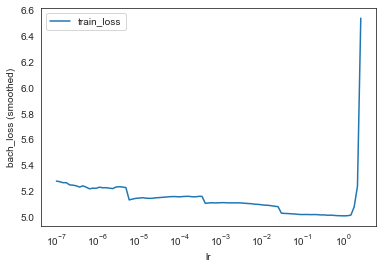

In [43]:
batch_size = 256
lrfind = model_2a.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [142]:
lrfinder.get_best_lr()

0.0613590727341321

In [12]:
model_2a.optimizer.set_lr(0.06)

In [13]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [16]:
%%time
log = model_2a.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.9289,	val_loss: 4.8702
1:	[0s / 0s],		train_loss: 4.8722,	val_loss: 4.8542
2:	[0s / 0s],		train_loss: 4.8527,	val_loss: 4.8479
3:	[0s / 1s],		train_loss: 4.8473,	val_loss: 4.8481
4:	[0s / 1s],		train_loss: 4.8480,	val_loss: 4.8451
5:	[0s / 1s],		train_loss: 4.8261,	val_loss: 4.8429
6:	[0s / 1s],		train_loss: 4.8305,	val_loss: 4.8438
7:	[0s / 2s],		train_loss: 4.8474,	val_loss: 4.8390
8:	[0s / 2s],		train_loss: 4.8389,	val_loss: 4.8478
9:	[0s / 2s],		train_loss: 4.8294,	val_loss: 4.8404
10:	[0s / 2s],		train_loss: 4.8237,	val_loss: 4.8377
11:	[0s / 3s],		train_loss: 4.8189,	val_loss: 4.8390
12:	[0s / 3s],		train_loss: 4.8057,	val_loss: 4.8357
13:	[0s / 3s],		train_loss: 4.8113,	val_loss: 4.8357
14:	[0s / 3s],		train_loss: 4.8164,	val_loss: 4.8362
15:	[0s / 4s],		train_loss: 4.8208,	val_loss: 4.8351
16:	[0s / 4s],		train_loss: 4.8182,	val_loss: 4.8396
17:	[0s / 4s],		train_loss: 4.8204,	val_loss: 4.8406
18:	[0s / 4s],		train_loss: 4.8198,	val_loss: 4.8410
19:

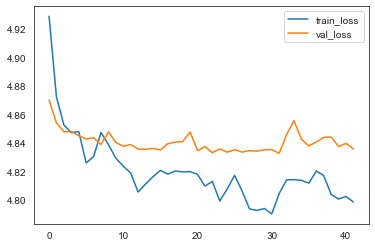

In [17]:
_ = log.plot()

In [18]:
model_2a.partial_log_likelihood(*val).mean()

-6.645707607269287

In [19]:
_ = model_2a.compute_baseline_hazards()

In [20]:
surv = model_2a.predict_surv_df(x_test)

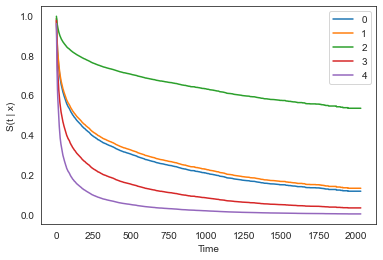

In [21]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [22]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [23]:
ev.concordance_td()

0.6204019143736325

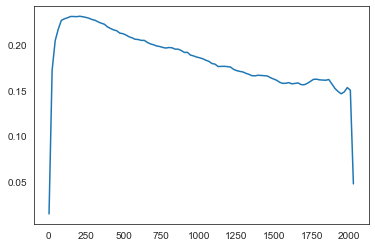

In [24]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

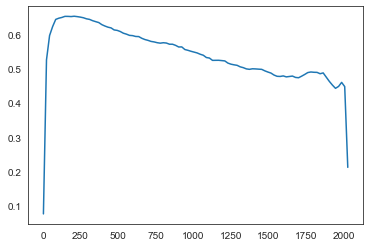

In [25]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.nbll(time_grid).plot()

In [26]:
ev.integrated_brier_score(time_grid)

0.18526120960200312

In [27]:
ev.integrated_nbll(time_grid)

0.5463343902637859

## 2 layers 64 nodes

In [44]:
in_features = x_train.shape[1]
num_nodes = [64, 64]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [45]:
model_2b = CoxPH(net, optimizer ) 

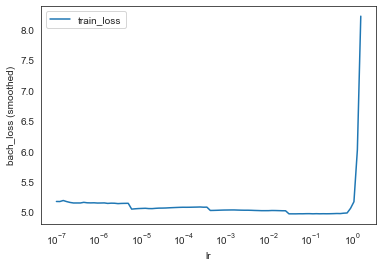

In [47]:
batch_size = 256
lrfind = model_2b.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [48]:
lrfinder.get_best_lr()

0.07390722033525823

In [49]:
model_2b.optimizer.set_lr(0.07)

In [50]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [51]:
%%time
log = model_2b.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 5.0533,	val_loss: 4.8729
1:	[0s / 0s],		train_loss: 4.8755,	val_loss: 4.8572
2:	[0s / 0s],		train_loss: 4.8566,	val_loss: 4.8484
3:	[0s / 1s],		train_loss: 4.8537,	val_loss: 4.8477
4:	[0s / 1s],		train_loss: 4.8448,	val_loss: 4.8371
5:	[0s / 1s],		train_loss: 4.8242,	val_loss: 4.8379
6:	[0s / 2s],		train_loss: 4.8238,	val_loss: 4.8382
7:	[0s / 2s],		train_loss: 4.8317,	val_loss: 4.8455
8:	[0s / 3s],		train_loss: 4.8393,	val_loss: 4.8342
9:	[0s / 3s],		train_loss: 4.8245,	val_loss: 4.8425
10:	[0s / 4s],		train_loss: 4.8246,	val_loss: 4.8396
11:	[0s / 4s],		train_loss: 4.8160,	val_loss: 4.8353
12:	[0s / 5s],		train_loss: 4.8075,	val_loss: 4.8320
13:	[0s / 5s],		train_loss: 4.7997,	val_loss: 4.8342
14:	[0s / 6s],		train_loss: 4.7940,	val_loss: 4.8334
15:	[0s / 6s],		train_loss: 4.8182,	val_loss: 4.8330
16:	[0s / 7s],		train_loss: 4.8154,	val_loss: 4.8404
17:	[0s / 7s],		train_loss: 4.8092,	val_loss: 4.8310
18:	[0s / 7s],		train_loss: 4.8003,	val_loss: 4.8373
19:

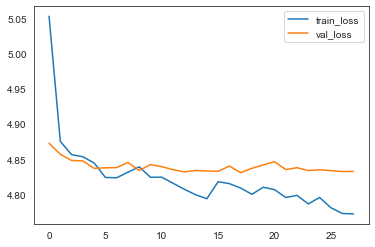

In [52]:
_ = log.plot()

In [53]:
model_2b.partial_log_likelihood(*val).mean()

-6.643601417541504

In [54]:
_ = model_2b.compute_baseline_hazards()

In [55]:
surv = model_2b.predict_surv_df(x_test)

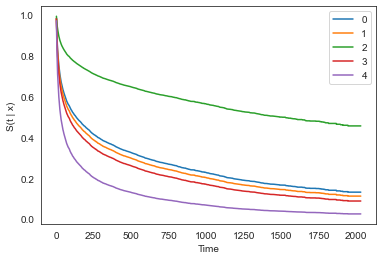

In [56]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [57]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [58]:
ev.concordance_td()

0.6233446024335184

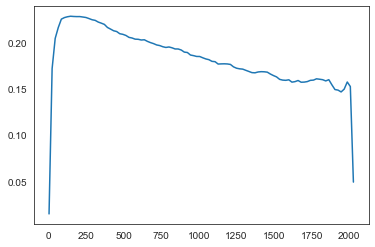

In [59]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

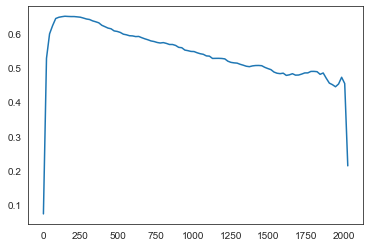

In [60]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.nbll(time_grid).plot()

In [61]:
ev.integrated_brier_score(time_grid)

0.1847334480442716

In [62]:
ev.integrated_nbll(time_grid)

0.5451114035386689